# 📊 Model Evaluation Notebook – Fire Detection Project

This notebook evaluates trained **ResNet-50 fire classification models** on either:

- ✅ **D-Fire outdoor real-world test set** (Phases 1–2, outdoor training evaluation)  
- ✅ **PLOS ONE indoor real-world test set** (Phase 3A domain shift, Phase 4 indoor deployment)

The test set can be selected at runtime using the `TESTSET` variable.  
The model checkpoint can be selected with the `model_filename` variable.

It supports evaluation of:
- ✅ Real-only models (e.g., `resnet_outdoor_real_100_phase1.pt`)  
- ✅ Synthetic-only models (e.g., `resnet_outdoor_synthetic_100_phase1.pt`)  
- ✅ Mixed real/synthetic models (e.g., `resnet_outdoor_50syn_50real_phase1.pt`)  
- ✅ Fine-tuned variants (Phase 2 checkpoints, e.g., `resnet_outdoor_real_ft_phase2.pt`)  
- ✅ Indoor-trained models (Phase 4 checkpoints, e.g., `resnet_indoor_real_100_phase4.pt`)  

Evaluation now includes:
- ✅ Computing **core metrics**: Accuracy, Precision, Recall, F1, Specificity, FPR/FNR, MCC  
- ✅ Generating and saving **Confusion Matrix**, **ROC curve**, and **PR curve** (saved + displayed inline)  
- ✅ Computing **threshold-free summaries**: ROC AUC and PR AUC  
- ✅ Saving all metrics (including **per-class Precision/Recall/F1/Support**) to JSON for later reporting  

📁 Output Files:
- `/results/metrics/{D_FIRE|PLOS_ONE}/<model>.json` → Full evaluation metrics (including per-class)  
- `/figures/confusion_matrices/{D_FIRE|PLOS_ONE}/<model>.png` → Confusion Matrix plots  
- `/figures/roc_curves/{D_FIRE|PLOS_ONE}/<model>.png` → ROC curve plots  
- `/figures/pr_curves/{D_FIRE|PLOS_ONE}/<model>.png` → PR curve plots  

---

## ⚙️ Usage Instructions

1. Set `model_filename` (e.g., `"resnet_outdoor_50syn_50real_phase1.pt"`)  
2. Set `TESTSET` to `"D_FIRE"` or `"PLOS_ONE"`  
3. Ensure the checkpoint exists in the `/models/` directory  
4. Run the notebook from top to bottom to:  
   - Load the model  
   - Evaluate on the selected test set  
   - View metrics and plots inline  
   - Save results (JSON + plots) to Drive for dissertation reporting  

---

## 🔥 Roadmap Alignment

| Phase      | Evaluation Target                        | Status        |
|------------|------------------------------------------|---------------|
| Phase 1    | Compare frozen ResNet-50 models (outdoor)| ✅ Completed  |
| Phase 2    | Evaluate fine-tuned variants             | ✅ Completed  |
| Phase 3A   | Outdoor → Indoor domain shift (PLOS ONE) | ✅ Completed  |
| Phase 3B   | Indoor synthetic → Outdoor               | ❌ Removed    |
| Phase 4    | Indoor deployment (Indoor test set)      | ✅ Completed  |

🧠 **Note**: This notebook now automatically saves **all metrics and plots** for each run. Per-class performance is available in the JSON outputs under `"per_class"`.


## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [3]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 170 (delta 88), reused 122 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (170/170), 4.35 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/fire-detection-dissertation


## 🧪 Step 1: Load the Evaluation Test Dataset (D-Fire or PLOS ONE)

In this step, we load the appropriate **hold-out test dataset** depending on the evaluation target:

- 🏞️ **D-Fire** – outdoor industrial dataset (standard benchmark for Phases 1–2 and Phase 3B)
- 🏠 **PLOS ONE** – indoor fire dataset (Phase 3A target for domain shift testing)

The test dataset to load is controlled via the `test_dataset_source` variable (`"D_FIRE"` or `"PLOS_ONE"`).  
All images are preprocessed using the same pipeline as in training: resized to 224×224 and converted to PyTorch tensors.

We use the unified `FireClassificationDataset` class, which handles label logic based on the dataset type (`real`, `plos`, or `synthetic`).

Maintaining consistent preprocessing and evaluation logic ensures fair comparison across all phases.


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationDataset

# 🔧 Choose test dataset source: "D_FIRE" or "PLOS_ONE"
test_dataset_source = "D_FIRE"  # Change to "PLOS_ONE" for indoor evaluation

# ✅ Set image and label directories based on the selected test dataset
if test_dataset_source == "D_FIRE":
    test_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/images"
    test_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/labels"
    dataset_type = "real"
elif test_dataset_source == "PLOS_ONE":
    test_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/test/images"
    test_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/test/labels"
    dataset_type = "plos"
else:
    raise ValueError("❌ Invalid test_dataset_source. Choose either 'D_FIRE' or 'PLOS_ONE'.")

# ✅ Define preprocessing transforms (same as used in training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Load test dataset and create DataLoader
test_dataset = FireClassificationDataset(
    image_dir=test_image_dir,
    label_dir=test_label_dir,
    transform=test_transforms,
    dataset_type=dataset_type
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Add suffix for naming saved results (used in Steps 3–5)
test_suffix = f"_{test_dataset_source}"


print(f"✅ Loaded {test_dataset_source} test set with {len(test_dataset)} images.")


✅ Loaded D_FIRE test set with 4306 images.


## 🧠 Step 2: Load the Trained ResNet-50 Model

In this step, we load a trained **ResNet-50** model from a saved checkpoint in the `/models/` directory.  
All models in this project use a **2-logit fully connected (FC) head** for binary classification (`[no fire, fire]`).

We instantiate a fresh ResNet-50, replace the final FC layer with 2 outputs, and then load the checkpoint weights.  
The model is then moved to the correct device (GPU if available, otherwise CPU) and set to evaluation mode.

To evaluate a different model, update the `model_filename` variable in the code cell below.


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

# 🔧 Select the model to evaluate (change this to test another checkpoint)
model_filename = "resnet_outdoor_real_100_phase1.pt"
checkpoint_path = f"/content/drive/MyDrive/fire-detection-dissertation/models/{model_filename}"

# Build a fresh ResNet-50 and set a 2-logit head (CE loss convention)
model = models.resnet50(weights=None)  # modern API; same functionality as pretrained=False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)

# Load checkpoint weights (support raw state_dict or wrapped dict)
ckpt = torch.load(checkpoint_path, map_location=device)
state_dict = ckpt.get("model_state_dict", ckpt)
model.load_state_dict(state_dict, strict=True)

# Move to device and eval mode
model = model.to(device)
model.eval()

print(f"✅ Loaded model: {model_filename} (2-logit head) and ready for evaluation.")


🔌 Using device: cuda
✅ Loaded model: resnet_outdoor_real_100_phase1.pt (2-logit head) and ready for evaluation.


## 📈 Step 3: Evaluate Model on Hold-Out Test Set

In this step, we run the loaded **ResNet-50** on the selected hold-out **test set** (D-Fire or PLOS ONE) and compute metrics.

**What’s new in this step (vs the old version):**
- We now compute **positive-class probabilities** (`y_prob_pos`) via `softmax` (index 1 = “fire”) so we can generate **ROC** and **PR** curves.
- We derive predicted labels by **thresholding** probabilities at **0.5** to stay consistent with the new helper.
- Instead of manual metric calculation and ad‑hoc saving, we call the upgraded one‑shot helper:
  `utils.metrics.evaluate_model(...)`, which:
  - writes a **JSON** with all metrics (Acc, Prec, Rec, F1, Specificity, FPR/FNR, MCC, ROC AUC, PR AUC),
  - saves **Confusion Matrix**, **ROC**, and **PR** plots to the correct folders.

Outputs are saved under:
- `results/metrics/{D_FIRE|PLOS_ONE}/<model_name>.json`
- `figures/confusion_matrices/{D_FIRE|PLOS_ONE}/<model_name>.png`
- `figures/roc_curves/{D_FIRE|PLOS_ONE}/<model_name>.png`
- `figures/pr_curves/{D_FIRE|PLOS_ONE}/<model_name>.png`



🔍 Starting evaluation for: resnet_outdoor_real_100_phase1.pt on D_FIRE
⏳ Running inference on test set...


🧪 Evaluating: 100%|██████████| 135/135 [25:17<00:00, 11.24s/batch]


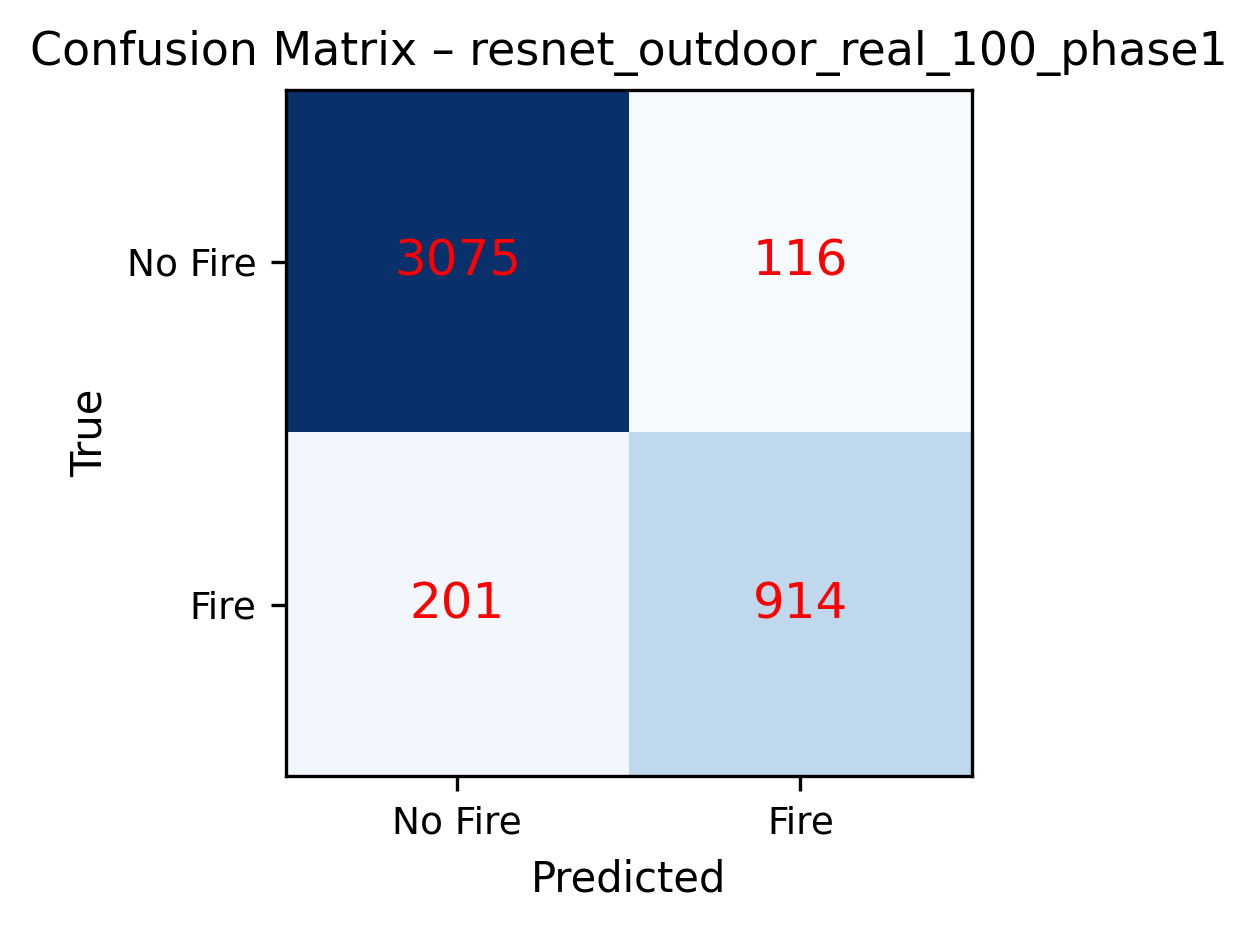

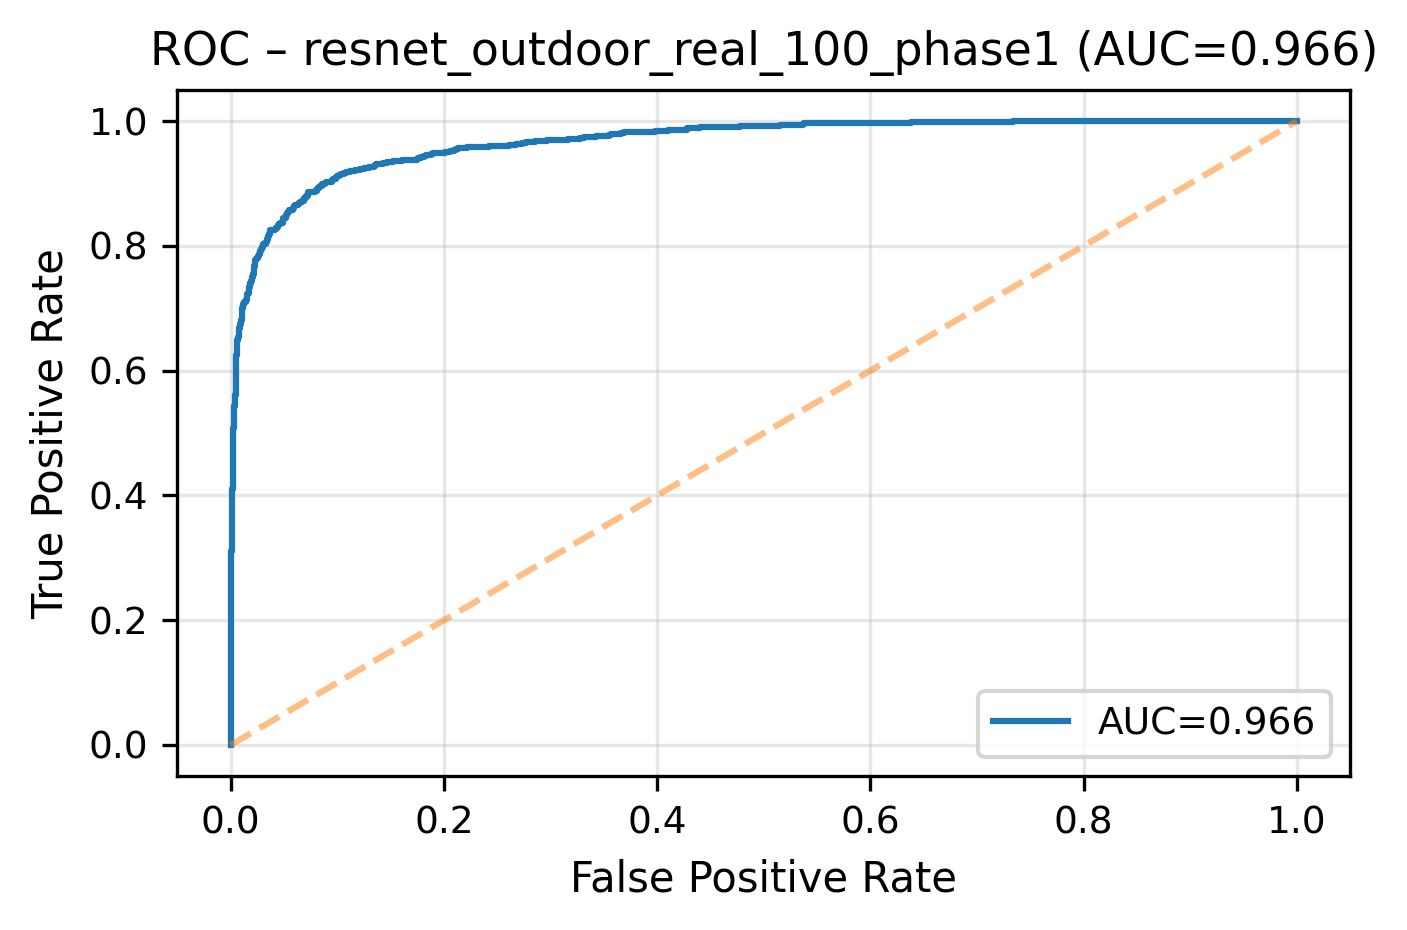

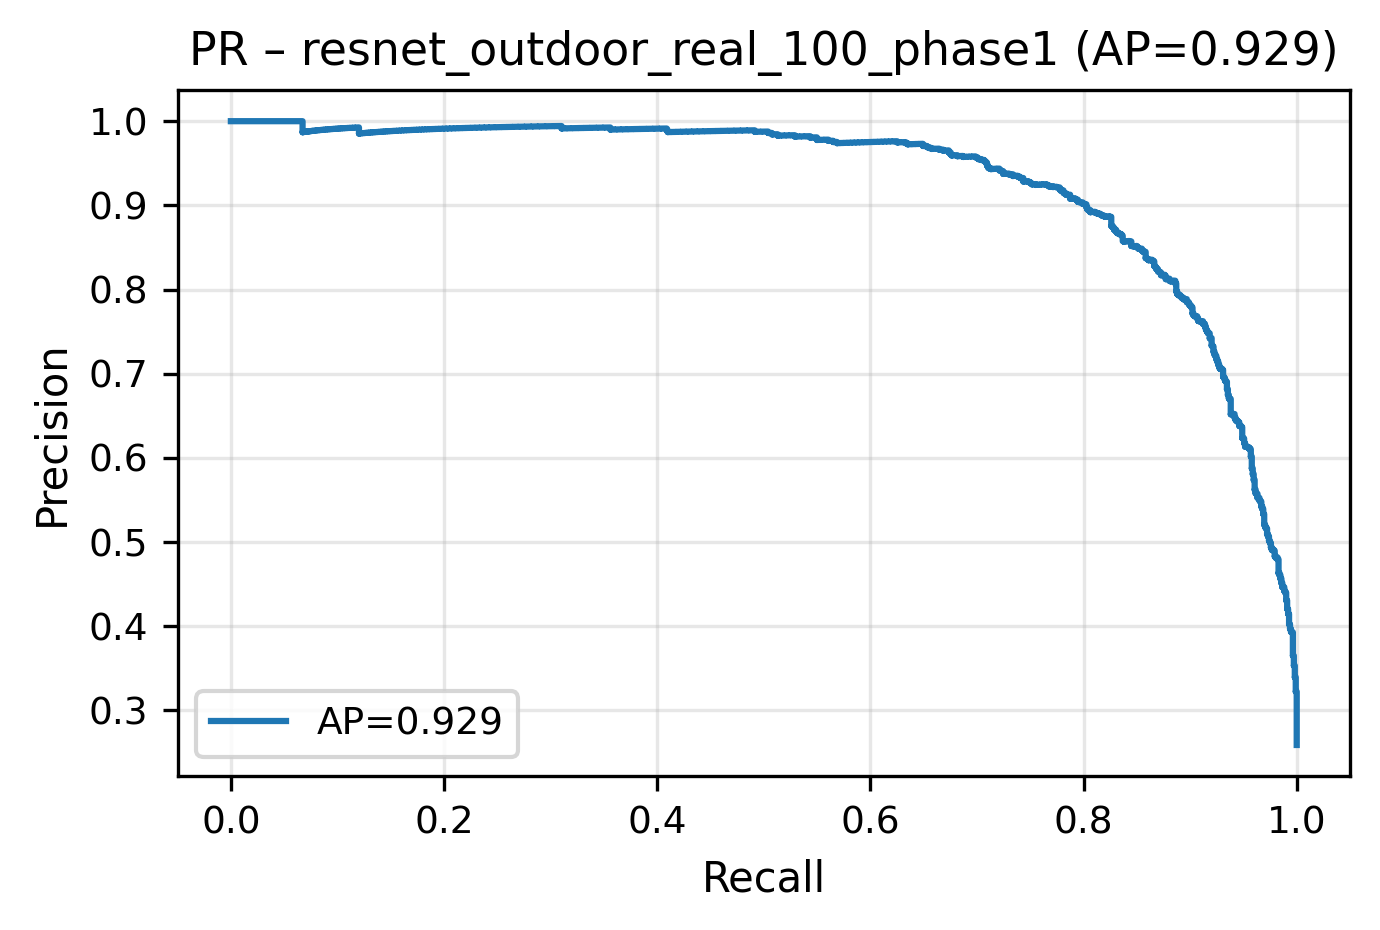

✅ Saved metrics and plots for resnet_outdoor_real_100_phase1 on D_FIRE

📊 Evaluation Summary
   accuracy: 0.92638179284719
  precision: 0.887378640776699
     recall: 0.8197309417040358
         f1: 0.8522144522144522
specificity: 0.9636477593230962
    roc_auc: 0.9662781955415526
     pr_auc: 0.9289609445267699
        mcc: 0.8044184749371646
        fpr: 0.03635224067690379
        fnr: 0.18026905829596412
         tp: 914
         tn: 3075
         fp: 116
         fn: 201


In [7]:
from utils.metrics import evaluate_model
from tqdm import tqdm
import torch
import numpy as np

# Containers
y_true_list = []
y_prob_list = []
y_pred_list = []

print(f"\n🔍 Starting evaluation for: {model_filename} on {test_dataset_source}")
print("⏳ Running inference on test set...")

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="🧪 Evaluating", unit="batch"):
        # Support either dict batches or tuple batches
        if isinstance(batch, dict):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
        else:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

        # Forward pass → 2-logit outputs
        logits = model(images)

        # Convert to probabilities of the positive class (index 1)
        probs = torch.softmax(logits, dim=1)
        prob_pos = probs[:, 1]

        # Predicted labels via 0.5 threshold (consistent with helper's convention)
        preds = (prob_pos >= 0.5).long()

        # Accumulate
        y_true_list.append(labels.detach().cpu())
        y_prob_list.append(prob_pos.detach().cpu())
        y_pred_list.append(preds.detach().cpu())

# Stack to 1D numpy arrays
y_true = torch.cat(y_true_list).numpy().reshape(-1)
y_prob_pos = torch.cat(y_prob_list).numpy().reshape(-1).astype(float)
y_pred = torch.cat(y_pred_list).numpy().reshape(-1)

# Strip ".pt" for cleaner filenames in outputs
model_name_no_ext = model_filename.replace(".pt", "")

# Delegate metrics + saving of JSON and plots to the helper
metrics = evaluate_model(
    model_name=model_name_no_ext,
    y_true=y_true,
    y_pred=y_pred,
    y_prob_pos=y_prob_pos,
    testset_name=test_dataset_source,  # expects "D_FIRE" or "PLOS_ONE"
    drive_base_dir="/content/drive/MyDrive/fire-detection-dissertation"
)

# Brief console summary
print("\n📊 Evaluation Summary")
for k in ["accuracy","precision","recall","f1","specificity","roc_auc","pr_auc","mcc","fpr","fnr","tp","tn","fp","fn"]:
    if k in metrics:
        print(f"{k:>11}: {metrics[k]}")


## 🧮 Step 4 (Optional): Console Classification Report

Per-class precision, recall, F1, and support are now **saved automatically** in the JSON output of `evaluate_model(...)` under the `"per_class"` section.  
This ensures all information needed for reporting is already persisted for every model.

This step is kept only as an **optional console view** for quick inspection during notebook runs.  
It prints the familiar `classification_report` table directly in the output cell, but does not save anything extra.


In [8]:
from sklearn.metrics import classification_report
import numpy as np

# y_true and y_pred come from Step 3 (already numpy 1D arrays there)
# If you kept them as tensors, just convert:
# y_true = y_true_tensor.numpy().reshape(-1)
# y_pred = y_pred_tensor.numpy().reshape(-1)

print("📝 Classification Report (per class):")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"], digits=4))


📝 Classification Report (per class):
              precision    recall  f1-score   support

     No Fire     0.9386    0.9636    0.9510      3191
        Fire     0.8874    0.8197    0.8522      1115

    accuracy                         0.9264      4306
   macro avg     0.9130    0.8917    0.9016      4306
weighted avg     0.9254    0.9264    0.9254      4306



## 🔍 (Optional) Grad‑CAM — Minimal, Targeted Explanations

This step generates a **small set of Grad‑CAM overlays** per model to visually inspect what the network attends to.

**Design:**  
- Pick **one True Positive (TP)**, **one False Positive (FP)**, and **one False Negative (FN)** from the Step 3 evaluation outputs.  
- Generate and save Grad‑CAM overlays for those indices only.

**Notes:**  
- Uses the last conv layer of **ResNet‑50** (`layer4[-1].conv3`).  
- Compatible with our **2‑logit** heads (softmax); if a 1‑logit variant appears in the future, code has a small branch.  
- Saves to: `figures/gradcam/<model_name>/<TESTSET>/case_<TP|FP|FN>_idx<k>.png`.  
- Intended for a few best models (not every checkpoint).


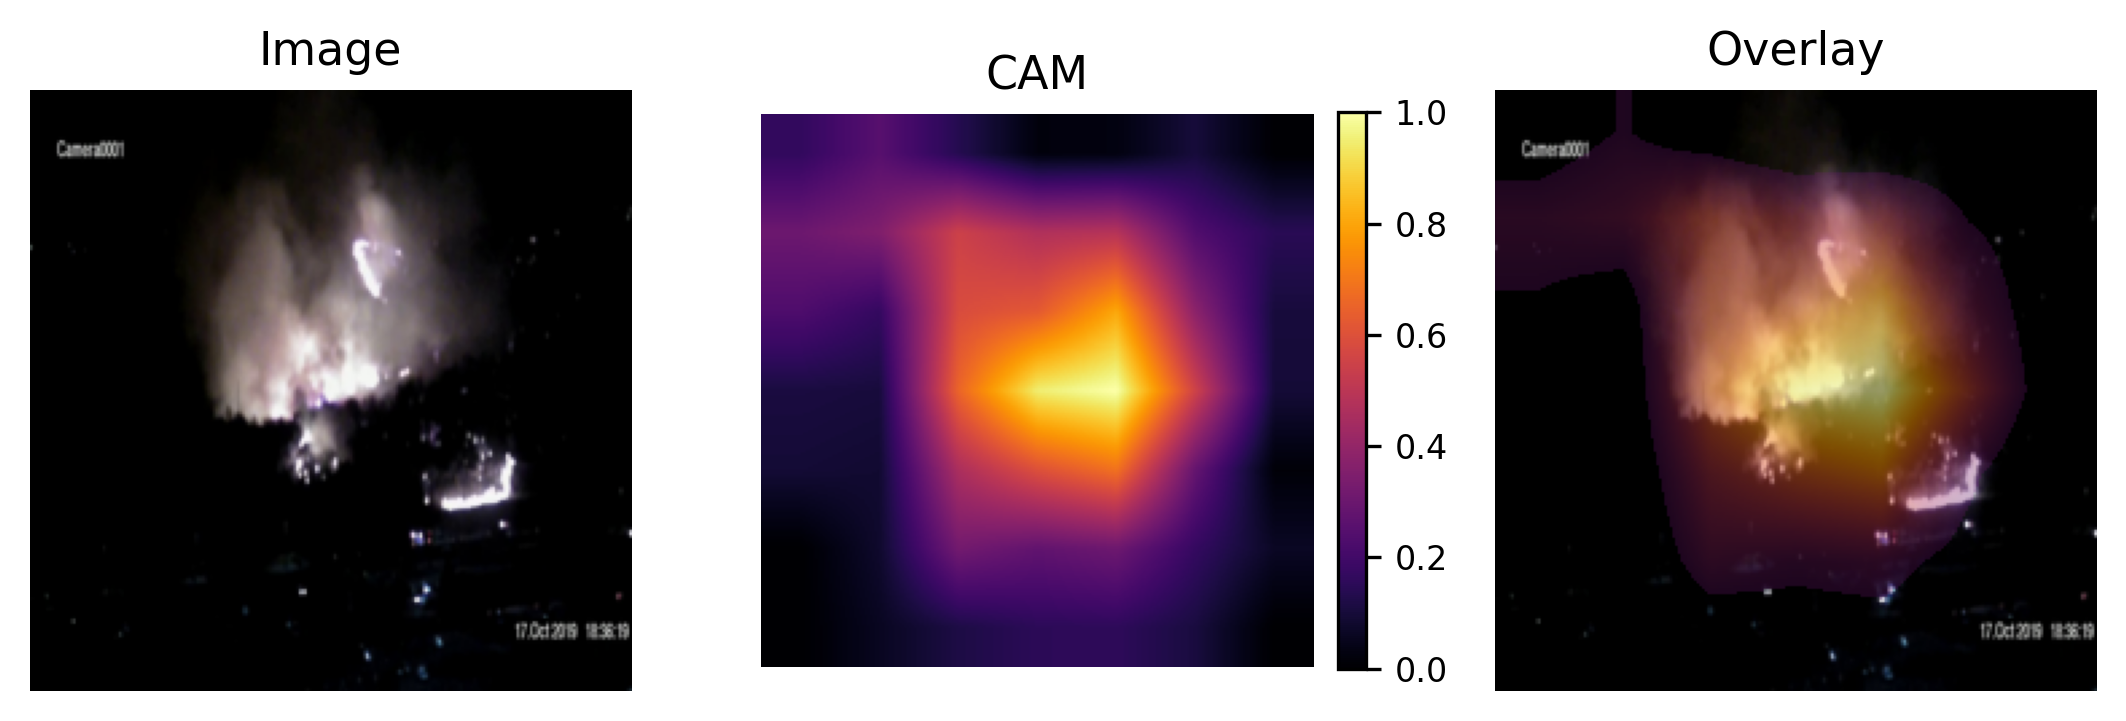

✅ Saved CAM panel: /content/drive/MyDrive/fire-detection-dissertation/figures/gradcam/resnet_outdoor_real_100_phase1/D_FIRE/case_TP_idx00995_y1_panel.png


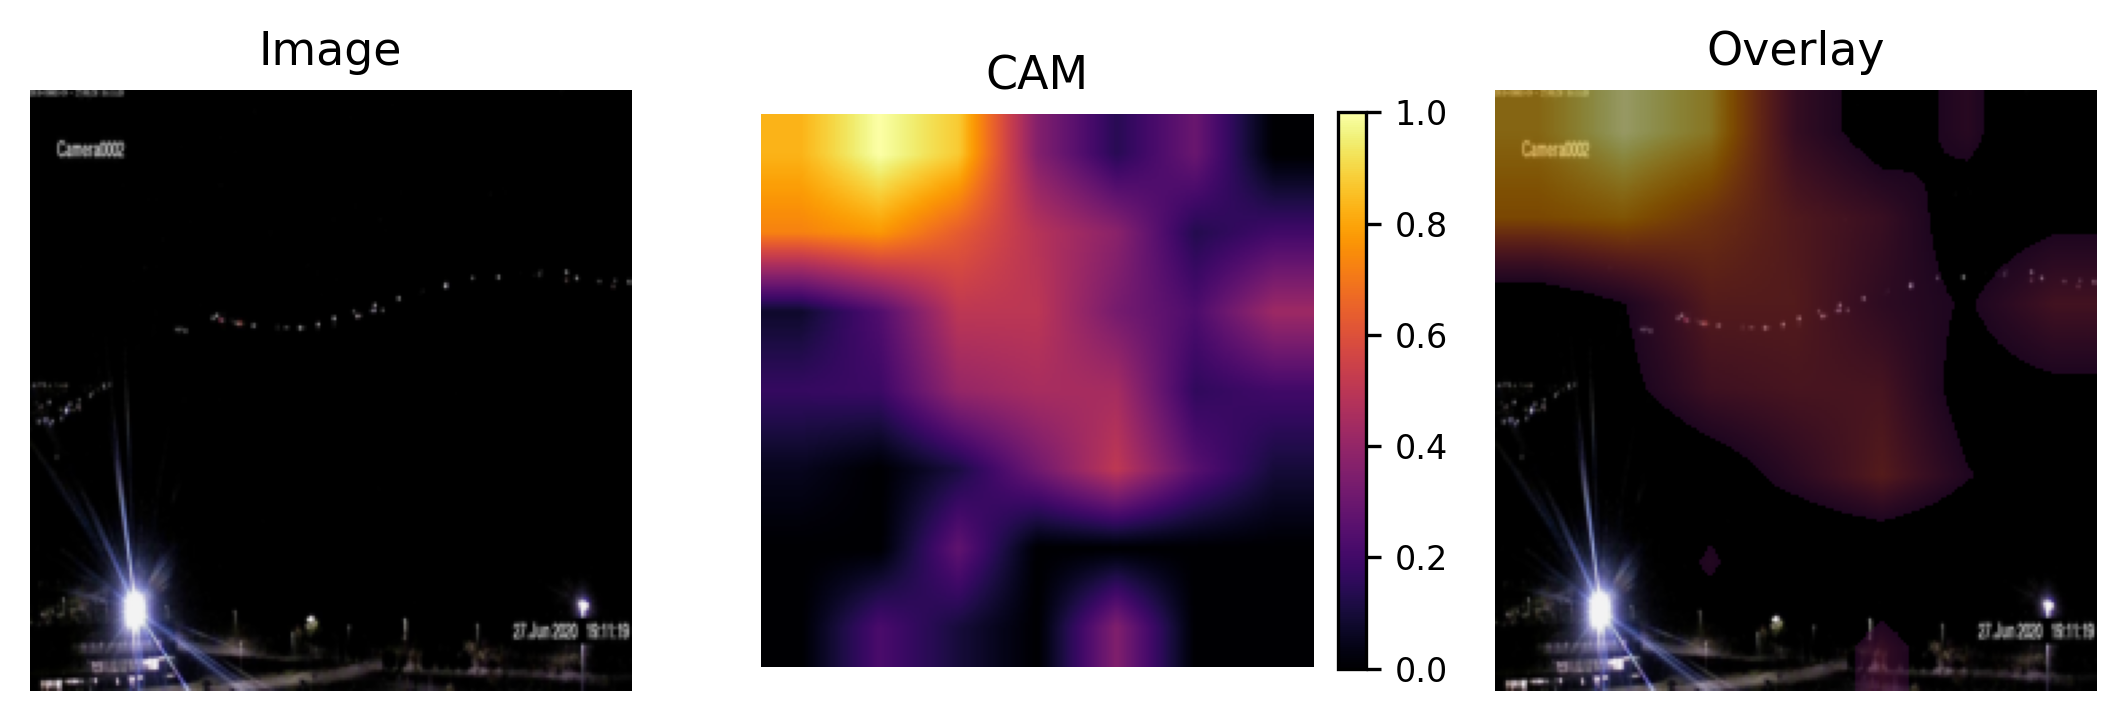

✅ Saved CAM panel: /content/drive/MyDrive/fire-detection-dissertation/figures/gradcam/resnet_outdoor_real_100_phase1/D_FIRE/case_FP_idx00026_y0_panel.png


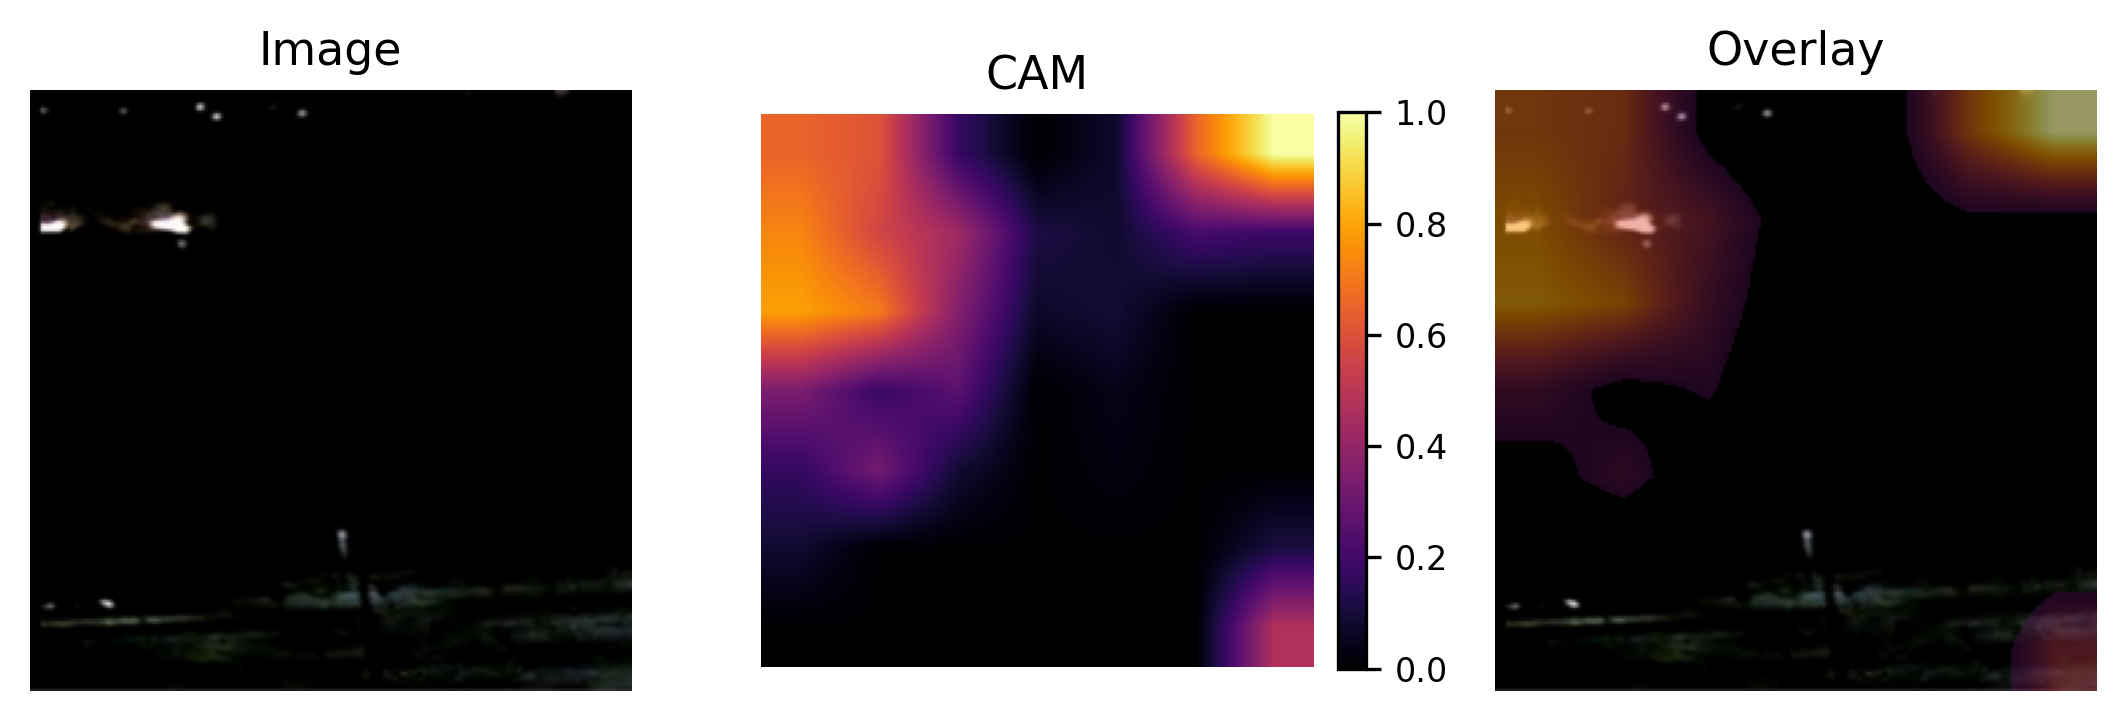

✅ Saved CAM panel: /content/drive/MyDrive/fire-detection-dissertation/figures/gradcam/resnet_outdoor_real_100_phase1/D_FIRE/case_FN_idx01142_y1_panel.png


In [14]:
# --- Grad-CAM (ResNet-50) — panels only ---

import os
import torch
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# 1) Choose representative indices for TP/FP/FN from Step 3 arrays
def pick_case_indices(y_true_np, y_pred_np):
    idxs = {"TP": None, "FP": None, "FN": None}
    tp = np.where((y_true_np == 1) & (y_pred_np == 1))[0]
    fp = np.where((y_true_np == 0) & (y_pred_np == 1))[0]
    fn = np.where((y_true_np == 1) & (y_pred_np == 0))[0]
    idxs["TP"] = int(tp[0]) if len(tp) else None
    idxs["FP"] = int(fp[0]) if len(fp) else None
    idxs["FN"] = int(fn[0]) if len(fn) else None
    return idxs

# 2) Target the output of the last bottleneck (post-residual), not conv3
def get_target_module(model):
    return model.layer4[-1]

class GradCAM:
    def __init__(self, model, target_module):
        self.model = model.eval()
        self.activations = None
        self.gradients = None
        self.fh = target_module.register_forward_hook(self._fwd_hook)
        self.bh = target_module.register_full_backward_hook(self._bwd_hook)

    def _fwd_hook(self, module, inp, out):
        self.activations = out  # [B,C,H,W] (post-ReLU features)

    def _bwd_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __del__(self):
        for h in (getattr(self, 'fh', None), getattr(self, 'bh', None)):
            try:
                h.remove()
            except Exception:
                pass

    def generate(self, image, pos_class_idx=1):
        """
        image: [1,3,224,224] on device, [0,1]
        pos_class_idx: 1 for 2-logit heads (Fire)
        """
        self.model.zero_grad()
        image.requires_grad_(True)
        logits = self.model(image)
        score = logits.squeeze() if logits.shape[-1] == 1 else logits[:, pos_class_idx].squeeze()
        score.backward(retain_graph=True)

        A  = self.activations          # [B,C,H,W]
        dA = self.gradients            # [B,C,H,W]
        weights = dA.mean(dim=(2,3), keepdim=True)         # GAP over H,W
        cam = (weights * A).sum(dim=1, keepdim=True)       # [B,1,H,W]
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=(224,224), mode="bilinear", align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

# 3) Convert CAM to overlay image array for the panel (no file saved here)
def cam_to_overlay(img_tensor, cam_np, base_alpha=0.15, max_alpha=0.6, hide_below=0.3, side=224):
    """
    img_tensor: [3,224,224] in [0,1]
    cam_np:     [224,224] in [0,1]
    Returns a NumPy uint8 HxWx3 overlay (no saving), used inside the panel.
    """
    cam = cam_np ** 0.85                                     # mild gamma for contrast
    alpha = base_alpha + (max_alpha - base_alpha) * cam
    alpha[cam < hide_below] = 0.0                            # suppress low activations

    heat_rgb = (cm.inferno(cam)[..., :3] * 255).astype(np.uint8)
    img = (img_tensor.detach().cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)

    over = (alpha[..., None] * heat_rgb + (1.0 - alpha[..., None]) * img).clip(0,255).astype(np.uint8)
    # return at panel size
    return np.array(Image.fromarray(over).resize((side, side), resample=Image.LANCZOS))

# 4) Save a triptych panel (Image | CAM | Overlay) as a single PNG
def save_cam_panel(img_tensor, cam_np, save_path_base):
    fig = plt.figure(figsize=(7.2, 2.4))   # single-column friendly
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    ax1.imshow(img); ax1.set_title("Image"); ax1.axis('off')

    im = ax2.imshow(cam_np, cmap='inferno', vmin=0, vmax=1)
    ax2.set_title("CAM"); ax2.axis('off')
    cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    over = cam_to_overlay(img_tensor, cam_np, side=224)
    ax3.imshow(over); ax3.set_title("Overlay"); ax3.axis('off')

    plt.tight_layout()
    panel_png = save_path_base + "_panel.png"
    plt.savefig(panel_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return panel_png

# 5) Driver: generate up to one TP, one FP, one FN CAM — PANELS ONLY
def run_gradcam_for_cases(model, dataset, case_indices, save_root, device, testset_key):
    model_name_no_ext = model_filename.replace(".pt", "")
    out_dir = os.path.join(save_root, model_name_no_ext, testset_key)
    os.makedirs(out_dir, exist_ok=True)

    cam_engine = GradCAM(model, get_target_module(model))

    for case_name, idx in case_indices.items():
        if idx is None:
            print(f"⚠️ No {case_name} case available; skipping.")
            continue

        sample = dataset[idx]
        if isinstance(sample, dict):
            img, label = sample["image"], int(sample["label"])
        else:
            img, label = sample
            label = int(label)

        img_b = img.unsqueeze(0).to(device)
        cam = cam_engine.generate(img_b, pos_class_idx=1)

        base = os.path.join(out_dir, f"case_{case_name}_idx{idx:05d}_y{label}")
        panel_png = save_cam_panel(img, cam, save_path_base=base)
        print(f"✅ Saved CAM panel: {panel_png}")

# ---- Execute (only if you want CAMs for this model) ----
try:
    test_dataset  # noqa
except NameError:
    test_dataset = test_loader.dataset

case_idxs = pick_case_indices(y_true, y_pred)

GRADCAM_ROOT = "/content/drive/MyDrive/fire-detection-dissertation/figures/gradcam"
TESTSET_KEY = test_dataset_source.upper()  # "D_FIRE" or "PLOS_ONE"

run_gradcam_for_cases(
    model=model,
    dataset=test_dataset,
    case_indices=case_idxs,
    save_root=GRADCAM_ROOT,
    device=device,
    testset_key=TESTSET_KEY,
)


In [ ]:
# ✅ 1. Navigate to your Git-tracked directory
%cd /content/fire-detection-dissertation

# ✅ 2. Copy updated notebook from Drive into Git repo (overwrite existing)
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/evaluate_models.ipynb /content/fire-detection-dissertation/notebooks/

# Optional: confirm it's there
!ls notebooks/

# ✅ 3. Stage changes for Git
!git add notebooks/evaluate_models.ipynb

# ✅ 4. Commit with an informative message
!git commit -m "Update evaluation notebook: integrate new metrics helper, per-class JSON output, and Grad-CAM support"

# ✅ 5. Push to GitHub
!git push


/content/fire-detection-dissertation
01_setup_environment.ipynb	      05_train_resnet_mixed_ratios.ipynb
02_data_preprocessing.ipynb	      06_train_resnet_finetuned.ipynb
03_train_resnet_real_only.ipynb       evaluate_models.ipynb
04_train_resnet_synthetic_only.ipynb
[main 26497e2] Update evaluation notebook: add modular support for multiple test datasets (D-Fire, PLOS ONE)
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/evaluate_models.ipynb (99%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 27.83 KiB | 13.91 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   a9e08bc..26497e2  main -> main
